In [1]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation, my_discrete_cmap
from flowrec.utils.py_helper import slice_from_tuple
from flowrec.utils.system import set_gpu
set_gpu(0,0.5)

In [2]:
result_dir = Path('../local_results/2dtriangle/repeat_noisy/noisy_random')
if not result_dir.exists():
    raise ValueError

In [3]:
def get_summary_one_case(folder):
    with h5py.File(Path(result_dir,folder,'summary.h5')) as hf:
        l_train = np.array(hf.get('runs_loss_train'))
        l_val = np.array(hf.get('runs_loss_val'))
        lmean = np.array([np.mean(l_train[:,0]), np.mean(l_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
        lstd = np.array([np.std(l_train[:,0]), np.std(l_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
        lpmean = np.array([
            np.mean(np.sum(l_train[:,1:3],axis=1)),
            np.mean(np.sum(l_val[:,1:3],axis=1))
        ])
        lpstd = np.array([
            np.std(np.sum(l_train[:,1:3],axis=1)),
            np.std(np.sum(l_val[:,1:3],axis=1))
        ])
 
    return lmean, lstd, lpmean, lpstd

## Load summary file

In [4]:
lmean_snr20_classic, lstd_snr20_classic, lpmean_snr20_classic, lpstd_snr20_classic = get_summary_one_case('snr20_classic')
lmean_snr20_3, lstd_snr20_3, lpmean_snr20_3, lpstd_snr20_3 = get_summary_one_case('snr20_3')
lmean_snr20_mean3, lstd_snr20_mean3, lpmean_snr20_mean3, lpstd_snr20_mean3 = get_summary_one_case('snr20_mean3')

lmean_snr10_classic, lstd_snr10_classic, lpmean_snr10_classic, lpstd_snr10_classic = get_summary_one_case('snr10_classic')
lmean_snr10_3, lstd_snr10_3, lpmean_snr10_3, lpstd_snr10_3 = get_summary_one_case('snr10_3')
lmean_snr10_mean3, lstd_snr10_mean3, lpmean_snr10_mean3, lpstd_snr10_mean3 = get_summary_one_case('snr10_mean3')

lmean_snr5_classic, lstd_snr5_classic, lpmean_snr5_classic, lpstd_snr5_classic = get_summary_one_case('snr5_classic')
lmean_snr5_3, lstd_snr5_3, lpmean_snr5_3, lpstd_snr5_3 = get_summary_one_case('snr5_3')
lmean_snr5_mean3, lstd_snr5_mean3, lpmean_snr5_mean3, lpstd_snr5_mean3 = get_summary_one_case('snr5_mean3')


Compare relative error

In [5]:
l_mean_classic = []
l_mean_classic.append(lmean_snr20_classic)
l_mean_classic.append(lmean_snr10_classic)
l_mean_classic.append(lmean_snr5_classic)
l_mean_classic = np.array(l_mean_classic)*100
l_std_classic = []
l_std_classic.append(lstd_snr20_classic)
l_std_classic.append(lstd_snr10_classic)
l_std_classic.append(lstd_snr5_classic)
l_std_classic = np.array(l_std_classic)*100

l_mean_3 = []
l_mean_3.append(lmean_snr20_3)
l_mean_3.append(lmean_snr10_3)
l_mean_3.append(lmean_snr5_3)
l_mean_3 = np.array(l_mean_3)*100
l_std_3 = []
l_std_3.append(lstd_snr20_3)
l_std_3.append(lstd_snr10_3)
l_std_3.append(lstd_snr5_3)
l_std_3 = np.array(l_std_3)*100

l_mean_mean3 = []
l_mean_mean3.append(lmean_snr20_mean3)
l_mean_mean3.append(lmean_snr10_mean3)
l_mean_mean3.append(lmean_snr5_mean3)
l_mean_mean3 = np.array(l_mean_mean3)*100
l_std_mean3 = []
l_std_mean3.append(lstd_snr20_mean3)
l_std_mean3.append(lstd_snr10_mean3)
l_std_mean3.append(lstd_snr5_mean3)
l_std_mean3 = np.array(l_std_mean3)*100

In [6]:
# l_mean_classic - rows: 20,10,5 snr. columns: training,testing

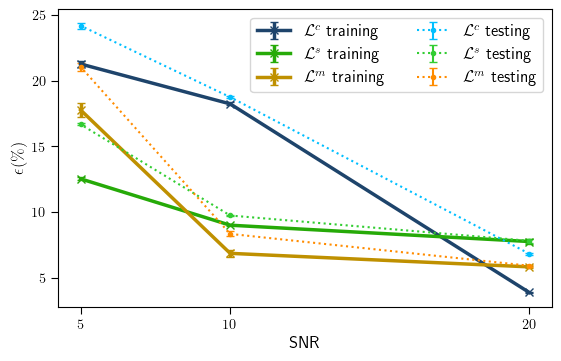

In [8]:
snr = [20,10,5]
plt.figure(figsize=(5.5,3.5))
ax = plt.subplot(111)

ax.errorbar(snr,l_mean_classic[:,0],yerr=l_std_classic[:,0],label='$\mathcal{L}^c$ training',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
ax.errorbar(snr,l_mean_3[:,0],yerr=l_std_3[:,0],label='$\mathcal{L}^s$ training',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
ax.errorbar(snr,l_mean_mean3[:,0],yerr=l_std_mean3[:,0],label='$\mathcal{L}^m$ training',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

ax.errorbar(snr,l_mean_classic[:,1],yerr=l_std_classic[:,1],label='$\mathcal{L}^c$ testing',marker='.',color='deepskyblue',linestyle=':')
ax.errorbar(snr,l_mean_3[:,1],yerr=l_std_3[:,1],label='$\mathcal{L}^s$ testing',marker='.',linestyle=':',color='limegreen')
ax.errorbar(snr,l_mean_mean3[:,1],yerr=l_std_mean3[:,1],label='$\mathcal{L}^m$ testing',marker='.',linestyle=':',color='darkorange',)

ax.legend(ncol=2)
ax.set_ylabel('$\epsilon (\%)$')
ax.set_xticks([5,10,20])
ax.set_xlabel('SNR')
# ax.set_yscale('log')
# plt.ylim([0,70])
# plt.savefig('./figs/noisy_compare_lossfn')
plt.show()

Compare physics loss

In [19]:
lp_mean_classic = []
lp_mean_classic.append(lpmean_snr20_classic)
lp_mean_classic.append(lpmean_snr10_classic)
lp_mean_classic.append(lpmean_snr5_classic)
lp_mean_classic = np.array(lp_mean_classic)
lp_std_classic = []
lp_std_classic.append(lpstd_snr20_classic)
lp_std_classic.append(lpstd_snr10_classic)
lp_std_classic.append(lpstd_snr5_classic)
lp_std_classic = np.array(lp_std_classic)

lp_mean_3 = []
lp_mean_3.append(lpmean_snr20_3)
lp_mean_3.append(lpmean_snr10_3)
lp_mean_3.append(lpmean_snr5_3)
lp_mean_3 = np.array(lp_mean_3)
lp_std_3 = []
lp_std_3.append(lpstd_snr20_3)
lp_std_3.append(lpstd_snr10_3)
lp_std_3.append(lpstd_snr5_3)
lp_std_3 = np.array(lp_std_3)

lp_mean_mean3 = []
lp_mean_mean3.append(lpmean_snr20_mean3)
lp_mean_mean3.append(lpmean_snr10_mean3)
lp_mean_mean3.append(lpmean_snr5_mean3)
lp_mean_mean3 = np.array(lp_mean_mean3)
lp_std_mean3 = []
lp_std_mean3.append(lpstd_snr20_mean3)
lp_std_mean3.append(lpstd_snr10_mean3)
lp_std_mean3.append(lpstd_snr5_mean3)
lp_std_mean3 = np.array(lp_std_mean3)

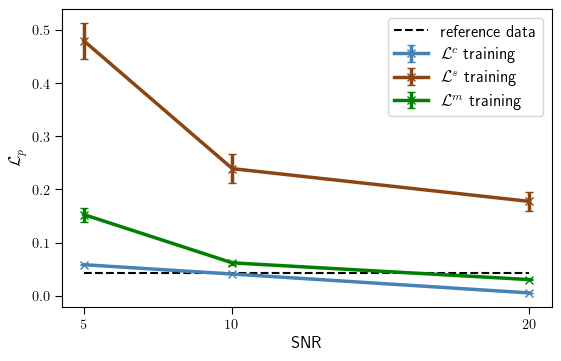

In [29]:
snr = [20,10,5]
plt.figure(figsize=(5.5,3.5))
ax = plt.subplot(111)

# training set
ax.errorbar(snr,lp_mean_classic[:,0],yerr=lp_std_classic[:,0],label='$\mathcal{L}^c$ training',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
ax.errorbar(snr,lp_mean_3[:,0],yerr=lp_std_3[:,0],label='$\mathcal{L}^s$ training',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
ax.errorbar(snr,lp_mean_mean3[:,0],yerr=lp_std_mean3[:,0],label='$\mathcal{L}^m$ training',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

#validation set
# ax.errorbar(snr,lp_mean_classic[:,1],yerr=lp_std_classic[:,1],label='$\mathcal{L}^c$ testing',marker='.',color='deepskyblue',linestyle=':')
# ax.errorbar(snr,lp_mean_3[:,1],yerr=lp_std_3[:,1],label='$\mathcal{L}^s$ testing',marker='.',linestyle=':',color='darkorange')
# ax.errorbar(snr,lp_mean_mean3[:,1],yerr=lp_std_mean3[:,1],label='$\mathcal{L}^m$ testing',marker='.',linestyle=':',color='limegreen',)

ax.hlines(0.043, xmin=5,xmax=20, colors=['k'], linestyles='dashed',label='reference data')
ax.legend(ncol=1)
ax.set_ylabel('$\mathcal{L}_p$')
ax.set_xticks([5,10,20])
ax.set_xlabel('SNR')
# ax.set_yscale('log')
# plt.ylim([0,70])
# plt.savefig('./figs/noisy_compare_lossfn_physics')
plt.show()